In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import spatial
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import string
import numpy as np
import random
from sklearn.metrics import classification_report,accuracy_score,balanced_accuracy_score, confusion_matrix
from scipy.linalg import eigh
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

# 1. TEXT CLASSIFICATION: IMDB data

# Load data

In [2]:
data = pd.read_csv("imdb.csv",index_col=0)
labels = data["Genre"]
X_train,X_test,y_train,y_test = train_test_split(data,labels, test_size = 0.10, random_state =0, stratify=labels)

print(f"Train length: {len(X_train)}")
print(f"Test length: {len(X_test)}")

Train length: 3964
Test length: 441


#### Preprocessing

In [3]:
categories      = ["Family","Sci-Fi","Thriller", "Romance"]
n_classes       = len(categories)
# We load the long plot of the movie from IMDB
train_texts     = list(X_train["LongPlot"].values)
test_texts      = list(X_test["LongPlot"].values)
train_labels_genre=list(y_train.values)
test_labels_genre=list(y_test.values)
le = preprocessing.LabelEncoder()
le.fit(categories)
train_labels = le.transform(train_labels_genre)
test_labels = le.transform(test_labels_genre)
print("Class balances:")
for i,c in enumerate(categories):
    print(c,np.mean(train_labels==i))

Class balances:
Family 0.1437941473259334
Sci-Fi 0.3433400605449041
Thriller 0.1236125126135217
Romance 0.38925327951564076


# GloVe

First, we load the pretrained Glove Vectors of dimensionality of 100 (https://nlp.stanford.edu/projects/glove/) into a dictionary where we can make the lookup for the specific glove vector dictionary\[word\]

In [4]:
filename = "glove.6B.100d.txt"

dictionary = {}
with open(filename,'r', encoding='utf-8') as file:
    for line in file:
        elements = line.split();
        word = elements[0];
        vector = np.asarray(elements[1:],"float32")
        dictionary[word] = vector;

#### Cleaning the text for GloVe:

A clean function to remove special characters and make everything lowercase is defined

In [5]:
def clean(text):
    """ Clean the text.
    Remove punctuation from the string and make it all lowercase """

    return text.translate(str.maketrans('', '', string.punctuation)).lower()

#### Converting the words to vectors and take the average for each movie plot

In [6]:

def get_glove_vectors(texts):
    """ Load the glove vectors and use the baseline method to represent the text as a vector.
     Args:
        texts (list): List of texts

    Returns:
        ndarray: Array of glove vectors
    """
    # Our predefined Glove Vectors have the dimensionality 100
    D = 100

    glove_vectors = np.zeros((len(texts),D))

    # Loop through texts
    for text_n, text in enumerate(texts):

        # Clean text and split into a list we can iterate through
        cleaned_text = clean(text)
        words = cleaned_text.split()


        glove = np.zeros((len(words),D))

        # Loop through the words in the text
        for key, word in enumerate(words):
            # If the glove vector does not exits just be a zero-vector
            try:
                glove[key] = dictionary[word]
            except:
                pass

        # Sum pretrained glove embeddings for the current text and divide by number of words in the text
        glove_vectors[text_n] = np.sum(glove,axis=0)*(1/len(words))
    return glove_vectors


In [7]:
train_glove_vectors = get_glove_vectors(train_texts)
test_glove_vectors = get_glove_vectors(test_texts)    

print(f"The shape of the train glove vectors is: {train_glove_vectors.shape}")
print(f"The shape of the test glove vectors is: {test_glove_vectors.shape}")

The shape of the train glove vectors is: (3964, 100)
The shape of the test glove vectors is: (441, 100)


# PCA of movie plots
Now that we have calculated the global vectors for the movie plots, we can calculate the principal components.

We use the PCA class imported from sklearn, but we also demonstrate how it can be calculated without the library.

## Making use of sklearn


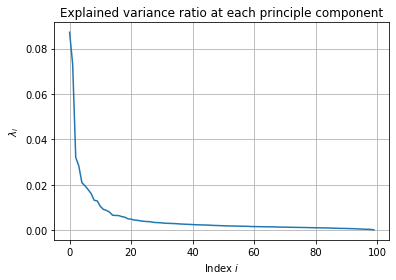

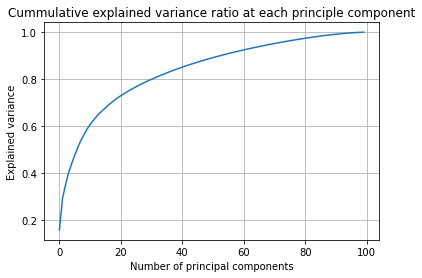

In [8]:
# import the PCA class from sklearn
from sklearn.decomposition import PCA

# Run PCA on the global vectors
pca_glove = PCA(n_components=100)
pca_glove.fit(train_glove_vectors)

# Calculate the explained variance
cum_explained_variance = np.cumsum(pca_glove.explained_variance_ratio_)

# Plot the explained variance
plt.plot(pca_glove.explained_variance_[:100]);
plt.title('Explained variance ratio at each principle component')
plt.xlabel('Index $i$')
plt.ylabel('$\lambda_i$')
plt.grid(True)
plt.show();

# Plot the cummulative explained variance
plt.plot(cum_explained_variance[:100]);
plt.title('Cummulative explained variance ratio at each principle component')
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance')
plt.grid(True)
plt.show();

## Without sklearn

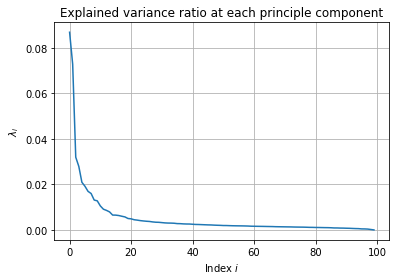

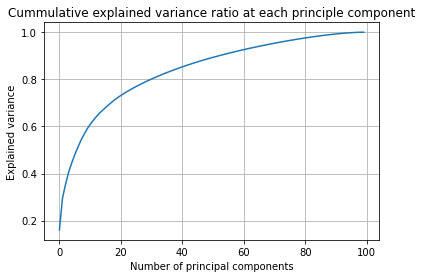

In [9]:
# The mean vector is calculated and subtracted from the global vectors
mean_vector = np.mean(train_glove_vectors,axis=1)
data = train_glove_vectors - mean_vector[:,None]

# compute the covariance matrix
S = np.cov(data.T)

# obtain eigenvectors and eigenvalues
eigen_values, eigen_vectors = eigh(S)

# The eigenvalues and vectors are sorted correctly
idx_ord         = np.argsort(eigen_values)[::-1]
eigen_values = eigen_values[idx_ord]
eigen_vectors = eigen_vectors[:,idx_ord]

# The total variance is calculated
T = sum(eigen_values)


cum_explained_variance = np.cumsum(eigen_values)/T

plt.plot(eigen_values[:100])
plt.title('Explained variance ratio at each principle component')
plt.xlabel('Index $i$')
plt.ylabel('$\lambda_i$')
plt.grid(True)
plt.show();

plt.plot(cum_explained_variance[:100]);
plt.title('Cummulative explained variance ratio at each principle component')
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance')
plt.grid(True)
plt.show();


(3964,) (3964,)


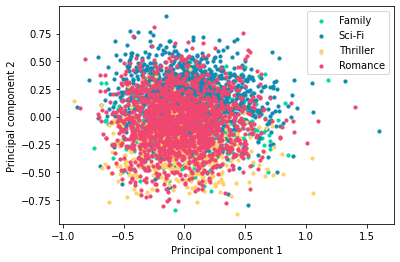

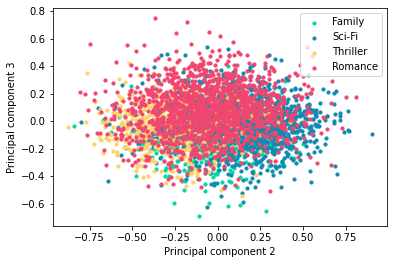

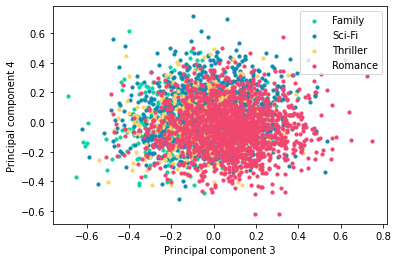

In [10]:
pca_glove_transform = pca_glove.transform(train_glove_vectors)

# Use PCA on test data
pca_glove_transform_test = pca_glove.transform(test_glove_vectors)

PC1 = pca_glove_transform[:,0]
PC2 = pca_glove_transform[:,1]

print(PC1.shape, PC2.shape)

PC3 = pca_glove_transform[:,2]
PC4 = pca_glove_transform[:,3]

group = np.array(train_labels)
cdict = {0: '#06d6a0', 1: '#118ab2', 2: '#ffd166', 3:'#ef476f'}
# categories      = ["Family","Sci-Fi","Thriller", "Romance"]
fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(PC1[ix], PC2[ix], c = cdict[g], label = categories[g], s = 10)
ax.legend()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(PC2[ix], PC3[ix], c = cdict[g], label = categories[g], s = 10)
ax.legend()
plt.xlabel('Principal component 2')
plt.ylabel('Principal component 3')
plt.show()


fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(PC3[ix], PC4[ix], c = cdict[g], label = categories[g], s = 10)
ax.legend()
plt.xlabel('Principal component 3')
plt.ylabel('Principal component 4')
plt.show()


# Classify genres based on the first n principal components of GloVe vectors

In [12]:
# Amount of principal components to try
K = [2, 5, 10, 20, 30, 40]

Making predictions based on the first K=10 principal components
Principal Components: 10, Train accuracy: 99.97%
Principal Components: 10, Test accuracy: 63.72%


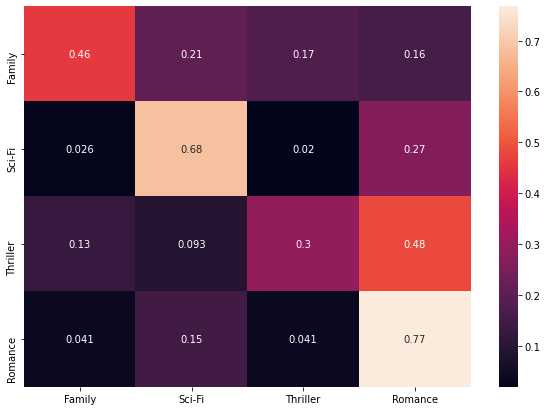

In [21]:
for k in K:
    clf_glove = RandomForestClassifier(random_state=0)
    clf_glove.fit(pca_glove_transform[:,:k], train_labels)

    print(f"Making predictions based on the first K={k} principal components")

    train_preds = clf_glove.predict(pca_glove_transform[:,:k])
    train_acc = np.mean(train_preds == train_labels)
    print(f"Principal Components: {k}, Train accuracy: {round(train_acc*100,2)}%")

    # Predict test data
    test_preds = clf_glove.predict(pca_glove_transform_test[:,:k])
    test_acc = np.mean(test_preds == test_labels)
    print(f"Principal Components: {k}, Test accuracy: {round(test_acc*100,2)}%")

Principal Components: 30, Test accuracy: 66.44%


<AxesSubplot:>

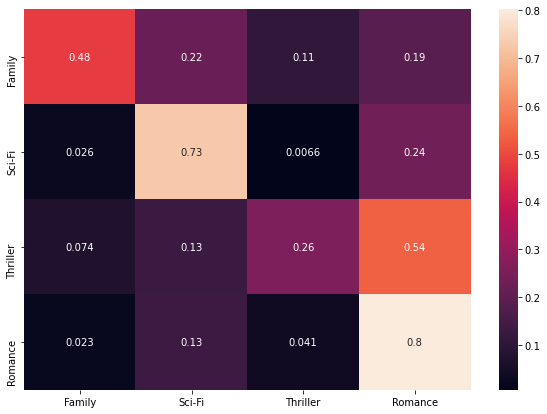

In [31]:
k = 30
clf_glove = RandomForestClassifier(random_state=0)
clf_glove.fit(pca_glove_transform[:,:k], train_labels)
# Predict test data
test_preds = clf_glove.predict(pca_glove_transform_test[:,:k])
test_acc = np.mean(test_preds == test_labels)
print(f"Principal Components: {k}, Test accuracy: {round(test_acc*100,2)}%")

cf_matrix = confusion_matrix(test_labels,test_preds,normalize='true')
df_cm = pd.DataFrame(cf_matrix, index = [i for i in categories], columns = [i for i in categories])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [13]:

def classify_glove(vec):
    """ Classify by looking at the 10 closest
    Args:
        vec (ndarray): Vector to classify

    Returns:
        int: predicted category

    """
    similarity_score = np.zeros(len(pca_glove_transform[:,:k]))

    for n, v in enumerate(pca_glove_transform[:,:k]):
        similarity_score[n] = spatial.distance.cosine(v,vec)
    # print(similarity_score)
        # break

    # bestFitIndex = np.argmin(similarity_score)
    # print(bestFitIndex)
    
    # Get the 5 lowet similarity scores
    best_fit_indices = np.argpartition(similarity_score,k)[:10]
    closest = train_labels[best_fit_indices]
    # print(closest)

    # Count the labels
    counts = np.bincount(best_fit_indices)
    # Get the highest count
    bestFitIndex = np.argmax(counts)

    category = train_labels[bestFitIndex]
    # category = 1
    return category
    # print(similarity_score)
    
# pca_test = pca.transform(test_glove_vectors)

# print(classify(pca_test[:,:K][1]))




In [14]:
for k in K:
    test_preds = np.zeros(len(pca_glove_transform_test[:,:k]))
    n = 0
    for test_text in tqdm(pca_glove_transform_test[:,:k]):
        test_preds[n] = classify_glove(test_text)
        n += 1

    print(f"Princial Components: {k}, Accuracy: {np.mean(test_preds == test_labels)}")

100%|██████████| 441/441 [01:04<00:00,  6.84it/s]Princial Components: 40, Accuracy: 0.49206349206349204



100%|██████████| 441/441 [01:36<00:00,  4.55it/s]


<AxesSubplot:>

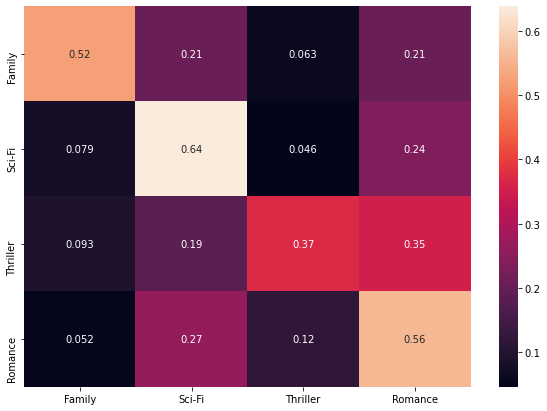

In [14]:
k = 30

test_preds = np.zeros(len(pca_glove_transform_test[:,:k]))
n = 0
for test_text in tqdm(pca_glove_transform_test[:,:k]):
    test_preds[n] = classify_glove(test_text)
    n += 1

cf_matrix = confusion_matrix(test_labels,test_preds,labels=[0,1,2,3],normalize='true')
df_cm = pd.DataFrame(cf_matrix, index = [i for i in categories], columns = [i for i in categories])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# FastText Classification using 3-gram embeddings

In [15]:
#########################################################################################################
# Adapted from: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
#########################################################################################################

import numpy as np
import random
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import TextClassificationDataset
from torchtext.vocab import Vocab
from torchtext.vocab import build_vocab_from_iterator

#####################################################################################################################
# Auxilary functions
#####################################################################################################################

tokenizer = get_tokenizer("basic_english")


def token_iterator(texts, ngrams):
    for text in texts:
        tokens = tokenizer(text)
        yield ngrams_iterator(tokens, ngrams)


def construct_vocab(texts, ngrams):
    vocab = build_vocab_from_iterator(token_iterator(texts, ngrams))
    return vocab


def text_to_tensor(text, vocab, ngrams):
    tokens = ngrams_iterator(tokenizer(text), ngrams=ngrams)
    token_ids = list(filter(lambda x: x is not Vocab.UNK, [vocab[token] for token in tokens]))
    tokens = torch.tensor(token_ids)
    return tokens


def make_torchdataset(vocab, texts, labels, ngrams):
    tokens = [text_to_tensor(text, vocab, ngrams) for text in tqdm(texts)]
    pairs = list(zip(labels, tokens))
    return TextClassificationDataset(vocab, pairs, set(labels))

def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

#####################################################################################################################
# Model
#####################################################################################################################


class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

#####################################################################################################################
# FastText
#####################################################################################################################


class FastText(object):

    def __init__(self, texts, labels, embed_dim, ngrams=3, num_epochs=5, seed=0):

        # set seed
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)


        self.texts = texts
        self.labels = labels
        self.embed_dim = embed_dim
        self.ngrams = ngrams

        # construct vocab
        print('Constructing vocabulary...')
        self.vocab = construct_vocab(texts, ngrams)
        self.vocab_size = len(self.vocab)

        # prepare dataset
        print('Preparing dataset...')
        self.train_dataset = make_torchdataset(self.vocab, texts, labels, ngrams)
        self.num_classes = len(self.train_dataset.get_labels())

        # prepare device ref and model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = TextClassificationModel(self.vocab_size, self.embed_dim, self.num_classes).to(self.device)

        # loss function & optimization
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=4.0)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
        self.batch_size = 16

        self.tokenizer = get_tokenizer("basic_english")
        self.ngrams = ngrams



        if num_epochs > 0:
            print('Training model...')
            self.train(self.train_dataset, num_epochs)


    def train_step(self, sub_train_):

        # Train the model
        train_loss = 0
        train_acc = 0
        data = DataLoader(sub_train_, batch_size=self.batch_size, shuffle=True, collate_fn=generate_batch)
        for i, (text, offsets, cls) in enumerate(data):
            self.optimizer.zero_grad()
            text, offsets, cls = text.to(device=self.device, dtype=torch.int64), offsets.to(device=self.device, dtype=torch.int64), cls.to(device=self.device, dtype=torch.int64)
            output = self.model(text, offsets)
            loss = self.criterion(output, cls)
            train_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            train_acc += (output.argmax(1) == cls).sum().item()

        # Adjust the learning rate
        self.scheduler.step()

        return train_loss / len(sub_train_),  train_acc / len(sub_train_)

    def compute_loss(self, data_):
        loss = 0
        acc = 0
        data = DataLoader(data_, batch_size=self.batch_size, collate_fn=generate_batch)
        for text, offsets, cls in data:
            text, offsets, cls = text.to(self.device), offsets.to(self.device), cls.to(self.device)
            with torch.no_grad():
                output = self.model(text, offsets)
                loss = self.criterion(output, cls)
                loss += loss.item()
                acc += (output.argmax(1) == cls).sum().item()

        return loss / len(data_), acc / len(data_)

    def train(self, train_dataset, n_epochs=5):

        min_valid_loss = float('inf')

        for epoch in range(n_epochs):
            start_time = time.time()
            train_loss, train_acc  = self.train_step(train_dataset)

            secs = int(time.time() - start_time)
            mins = secs / 60
            secs = secs % 60

            print('Epoch: %d' % (epoch + 1), " | time in %d minutes, %d seconds" % (mins, secs))
            print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        print('')

    def predict(self, text_, return_prob=False):

        with torch.no_grad():
            text = text_to_tensor(text_, self.vocab, self.ngrams)
            output = self.model(text, torch.tensor([0]))

            if return_prob:
                return F.softmax(output, 1).detach().numpy()
            else:
                return output.argmax(1).item()

    def get_text_embedding(self, text_):
        with torch.no_grad():
            text = text_to_tensor(text_, self.vocab, self.ngrams)
            return self.model.embedding(text, offsets=torch.LongTensor([0])).detach().numpy()

    def word_in_vocab(self, word):
        return word in self.vocab.stoi




In [16]:
D = 100
# Usage example:
model = FastText(train_texts,train_labels,embed_dim=D,num_epochs=15)

363lines [00:00, 3606.07lines/s]Constructing vocabulary...
3964lines [00:01, 3060.61lines/s]
100%|██████████| 3964/3964 [00:02<00:00, 1501.37it/s]
Training model...
Epoch: 1  | time in 0 minutes, 5 seconds
	Loss: 0.0845(train)	|	Acc: 39.0%(train)
Epoch: 2  | time in 0 minutes, 7 seconds
	Loss: 0.0779(train)	|	Acc: 44.0%(train)
Epoch: 3  | time in 0 minutes, 8 seconds
	Loss: 0.0702(train)	|	Acc: 51.6%(train)
Epoch: 4  | time in 0 minutes, 9 seconds
	Loss: 0.0631(train)	|	Acc: 58.5%(train)
Epoch: 5  | time in 0 minutes, 8 seconds
	Loss: 0.0541(train)	|	Acc: 65.7%(train)
Epoch: 6  | time in 0 minutes, 9 seconds
	Loss: 0.0461(train)	|	Acc: 73.7%(train)
Epoch: 7  | time in 0 minutes, 9 seconds
	Loss: 0.0391(train)	|	Acc: 79.1%(train)
Epoch: 8  | time in 0 minutes, 8 seconds
	Loss: 0.0324(train)	|	Acc: 85.3%(train)
Epoch: 9  | time in 0 minutes, 8 seconds
	Loss: 0.0278(train)	|	Acc: 88.4%(train)
Epoch: 10  | time in 0 minutes, 8 seconds
	Loss: 0.0234(train)	|	Acc: 91.7%(train)
Epoch: 11  | t

# Classification on test set

In [17]:
test_predicts = np.zeros(len(test_texts))

for idx, text in enumerate(test_texts):
    # print(categories[model.predict(text)])
    test_predicts[idx] = model.predict(text)
   
# print(classification_report(test_labels, test_predicts))
print(f"Accuracy: {accuracy_score(test_labels, test_predicts)*100}%")
print(f"Accuracy: {balanced_accuracy_score(test_labels, test_predicts)*100}%")

Accuracy: 62.131519274376416%
Accuracy: 48.52793320510579%


In [21]:
categories      = ["Family","Sci-Fi","Thriller", "Romance"]

print(len(np.where(test_predicts == 0)[0])/len(test_labels))
print(len(np.where(test_predicts == 1)[0])/len(test_labels))
print(len(np.where(test_predicts == 2)[0])/len(test_labels))
print(len(np.where(test_predicts == 3)[0])/len(test_labels))


0.09977324263038549
0.30839002267573695
0.0
0.5918367346938775


<AxesSubplot:>

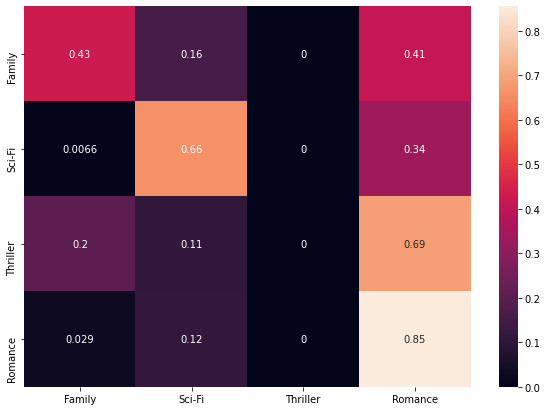

In [22]:
cf_matrix = confusion_matrix(test_labels,test_predicts,labels=[0,1,2,3],normalize='true')
df_cm = pd.DataFrame(cf_matrix, index = [i for i in categories], columns = [i for i in categories])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# PCA on FastText embeddings

First, we get the FastText embeddings for each text from the model

In [23]:
test_fasttext_embeddings = np.zeros((len(test_texts),D))
train_fasttext_embeddings = np.zeros((len(train_texts),D))

for idx, text in enumerate(test_texts):
    # print(categories[model.predict(text)])
    test_fasttext_embeddings[idx] = model.get_text_embedding(text)

for idx, text in enumerate(train_texts):
    # print(categories[model.predict(text)])
    train_fasttext_embeddings[idx] = model.get_text_embedding(text)


Now we run PCA on this and plot the explained variance ratio

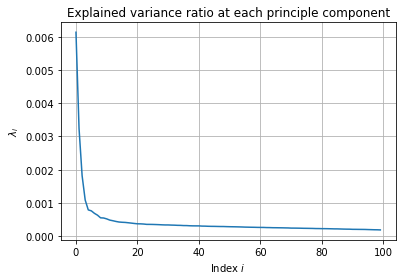

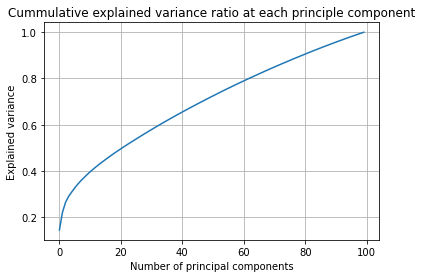

In [24]:
from sklearn.decomposition import PCA

# Run PCA on the global vectors
pca_fasttext = PCA(n_components=100)
pca_fasttext.fit(train_fasttext_embeddings)

# Calculate the explained variance
cum_explained_variance = np.cumsum(pca_fasttext.explained_variance_ratio_)

# Plot the explained variance
plt.plot(pca_fasttext.explained_variance_[:100]);
plt.title('Explained variance ratio at each principle component')
plt.xlabel('Index $i$')
plt.ylabel('$\lambda_i$')
plt.grid(True)
plt.show();

# Plot the cummulative explained variance
plt.plot(cum_explained_variance[:100]);
plt.title('Cummulative explained variance ratio at each principle component')
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance')
plt.grid(True)
plt.show();
# # print(classification_report(test_labels, test_predicts))
# print(f"Accuracy: {accuracy_score(test_labels, test_predicts)*100}%")
# print(f"Accuracy: {balanced_accuracy_score(test_labels, test_predicts)*100}%")

# model.get_text_embedding(test_texts[1]).flatten()

The principal components PC1 and PC2, PC2 and PC3, and PC3 and PC4 are shown in a plot 

(3964,) (3964,)


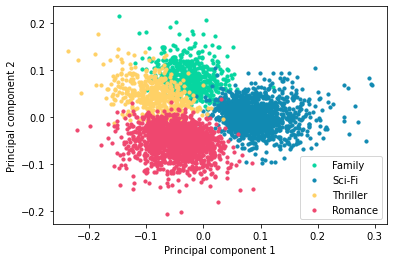

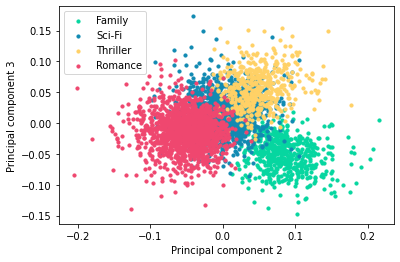

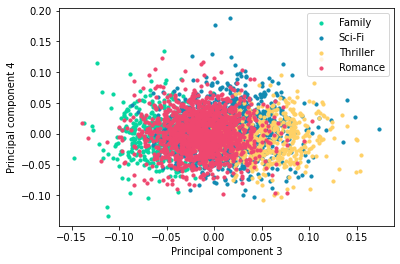

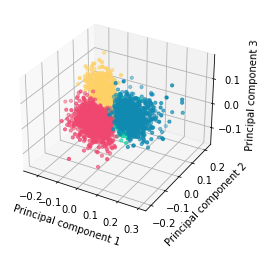

In [25]:
pca_fasttext_transform = pca_fasttext.transform(train_fasttext_embeddings)

# Use PCA on test data
pca_fasttext_transform_test = pca_fasttext.transform(test_fasttext_embeddings)


PC1 = pca_fasttext_transform[:,0]
PC2 = pca_fasttext_transform[:,1]

print(PC1.shape, PC2.shape)

PC3 = pca_fasttext_transform[:,2]
PC4 = pca_fasttext_transform[:,3]


group = np.array(train_labels)
cdict = {0: '#06d6a0', 1: '#118ab2', 2: '#ffd166', 3:'#ef476f'}
# categories      = ["Family","Sci-Fi","Thriller", "Romance"]
fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(PC1[ix], PC2[ix], c = cdict[g], label = categories[g], s = 10)
ax.legend()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(PC2[ix], PC3[ix], c = cdict[g], label = categories[g], s = 10)
ax.legend()
plt.xlabel('Principal component 2')
plt.ylabel('Principal component 3')
plt.show()


fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(PC3[ix], PC4[ix], c = cdict[g], label = categories[g], s = 10)
ax.legend()
plt.xlabel('Principal component 3')
plt.ylabel('Principal component 4')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(PC1[ix], PC2[ix], PC3[ix], c = cdict[g], label = categories[g], s = 10)

# 
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Principal component 3')
# rotate the axes and update

plt.show()

In [26]:
K = [2,3,4,5,10,20,30,40,50]

In [22]:
from sklearn.ensemble import RandomForestClassifier

for k in K:
    clf_fasttext = RandomForestClassifier(random_state=0)
    clf_fasttext.fit(pca_fasttext_transform[:,:k], train_labels)

    print(f"Making predictions based on the first K={k} principal components")

    train_preds = clf_fasttext.predict(pca_fasttext_transform[:,:k])
    train_acc = np.mean(train_preds == train_labels)
    print(f"Principal Components: {k}, Train accuracy: {round(train_acc*100,2)}%")

    # Predict test data
    test_preds = clf_fasttext.predict(pca_fasttext_transform_test[:,:k])
    test_acc = np.mean(test_preds == test_labels)
    print(f"Principal Components: {k}, Test accuracy: {round(test_acc*100,2)}%")


Making predictions based on the first K=2 principal components
Principal Components: 2, Train accuracy: 99.97%
Principal Components: 2, Test accuracy: 58.05%
Making predictions based on the first K=3 principal components
Principal Components: 3, Train accuracy: 99.97%
Principal Components: 3, Test accuracy: 62.13%
Making predictions based on the first K=4 principal components
Principal Components: 4, Train accuracy: 99.97%
Principal Components: 4, Test accuracy: 60.77%
Making predictions based on the first K=5 principal components
Principal Components: 5, Train accuracy: 99.97%
Principal Components: 5, Test accuracy: 62.59%
Making predictions based on the first K=10 principal components
Principal Components: 10, Train accuracy: 99.97%
Principal Components: 10, Test accuracy: 63.04%
Making predictions based on the first K=20 principal components
Principal Components: 20, Train accuracy: 99.97%
Principal Components: 20, Test accuracy: 57.14%
Making predictions based on the first K=30 pri

Principal Components: 3, Test accuracy: 62.13%
[[0.44444444 0.26984127 0.         0.28571429]
 [0.01973684 0.70394737 0.         0.27631579]
 [0.24074074 0.11111111 0.         0.64814815]
 [0.02325581 0.16860465 0.         0.80813953]]


<AxesSubplot:>

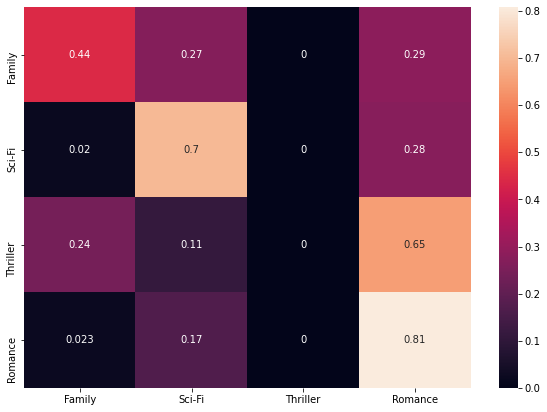

In [27]:
k = 3
clf_fasttext = RandomForestClassifier(random_state=0)
clf_fasttext.fit(pca_fasttext_transform[:,:k], train_labels)

# Predict test data
test_preds = clf_fasttext.predict(pca_fasttext_transform_test[:,:k])
test_acc = np.mean(test_preds == test_labels)
print(f"Principal Components: {k}, Test accuracy: {round(test_acc*100,2)}%")

cf_matrix = confusion_matrix(test_labels,test_preds,labels=[0,1,2,3],normalize='true')
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in categories], columns = [i for i in categories])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [28]:
def classify_fasttext(vec):
    similarity_score = np.zeros(len(pca_fasttext_transform[:,:k]))

    for n, v in enumerate(pca_fasttext_transform[:,:k]):
        similarity_score[n] = spatial.distance.cosine(v,vec)

      
    # Get the 5 lowet similarity scores
    best_fit_indices = np.argpartition(similarity_score,k)[:10]
    closest = train_labels[best_fit_indices]
    # print(closest)

    # Count the labels
    counts = np.bincount(best_fit_indices)
    # Get the highest count
    bestFitIndex = np.argmax(counts)

    category = train_labels[bestFitIndex]
    
    return category

In [24]:
for k in K:
    test_preds = np.zeros(len(pca_fasttext_transform_test[:,:k]))
    n = 0
    for test_text in tqdm(pca_fasttext_transform_test[:,:k]):
        test_preds[n] = classify_fasttext(test_text)
        n += 1

    print(f"Princial Components: {k}, Accuracy: {np.mean(test_preds == test_labels)}")

100%|██████████| 441/441 [01:13<00:00,  5.99it/s]Princial Components: 50, Accuracy: 0.5011337868480725



100%|██████████| 441/441 [01:12<00:00,  6.12it/s]


<AxesSubplot:>

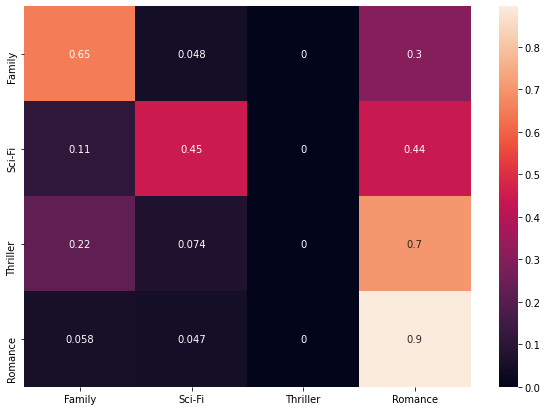

In [29]:
k = 3
test_preds = np.zeros(len(pca_fasttext_transform_test[:,:k]))
n = 0
for test_text in tqdm(pca_fasttext_transform_test[:,:k]):
    test_preds[n] = classify_fasttext(test_text)
    n += 1

cf_matrix = confusion_matrix(test_labels,test_preds,labels=[0,1,2,3],normalize='true')
df_cm = pd.DataFrame(cf_matrix, index = [i for i in categories], columns = [i for i in categories])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Write your own plot and see what genre GloVe+PCA+classifier and FastText guess it is

In [35]:
plot = "When the Earth is invaded by alien technology a single human rises up to battle. His name is John Cena. He battles the invasion for weeks, using the most technologically advanced cybernetics. John Cena wins the battle against the aliens, but instantly a new enemy emerges through a timetravelling wormhole. Futuristic robots with laser-eyes. The robots end up killing John Cena, but before he died he planted a quantum bomb inside one of the robots which opens a giant black hole in the middle of Earth killing everything in the Milkyway."
plot = clean(plot)

k=3

custom_plot_glove_embed = get_glove_vectors(np.array([plot]))
glove_text_pca_pred = classify_glove(pca_fasttext.transform(custom_plot_glove_embed)[:,:k])

# print(custom_plot_glove_embed)

custom_plot_fasttext_embed = model.get_text_embedding(plot)
fast_text_pca_pred = classify_fasttext(pca_fasttext.transform(custom_plot_fasttext_embed)[:,:k])

clf_glove = RandomForestClassifier(random_state=0)
clf_glove.fit(pca_glove_transform[:,:k], train_labels)

clf_fasttext = RandomForestClassifier(random_state=0)
clf_fasttext.fit(pca_fasttext_transform[:,:k], train_labels)

fasttext_pred = model.predict(plot)
print("Predictions:")
print(f"Glove Random Forest Classification: {categories[clf_glove.predict(custom_plot_glove_embed[:,:k])[0]]}")
print(f"Glove PCA/cosine similarity: {categories[glove_text_pca_pred]}")
print()
print(f"FastText Random Forest Classification: {categories[clf_fasttext.predict(custom_plot_fasttext_embed[:,:k])[0]]}")
print(f"Fasttext model: {categories[fasttext_pred]}")
print(f"Fasttext PCA/cosine similarity: {categories[fast_text_pca_pred]}")



Predictions:
Glove Random Forest Classification: Romance
Glove PCA/cosine similarity: Thriller

FastText Random Forest Classification: Romance
Fasttext model: Romance
Fasttext PCA/cosine similarity: Romance


# 2. SENTIMENT ANALYSIS: The Donald

In [26]:
text = np.loadtxt("Donald.txt",dtype='str')
text_cleaned = []
for word in text:
    
    # to lower
    doc_cleaned = word.lower()
    
    #doc_cleaned = ' '.join([word for word in doc_cleaned.split() if word not in stop_words])    
    doc_cleaned = doc_cleaned.replace('.', '')
    doc_cleaned = doc_cleaned.replace(',', '')
    doc_cleaned = doc_cleaned.replace('?', '')
    doc_cleaned = doc_cleaned.replace('!', '')
    text_cleaned.append(doc_cleaned)


In [27]:
print(text_cleaned)

['chief', 'justice', 'roberts', 'president', 'carter', 'president', 'clinton', 'president', 'bush', 'president', 'obama', 'fellow', 'americans', 'and', 'people', 'of', 'the', 'world', 'thank', 'you', 'we', 'the', 'citizens', 'of', 'america', 'are', 'now', 'joined', 'in', 'a', 'great', 'national', 'effort', 'to', 'rebuild', 'our', 'country', 'and', 'restore', 'its', 'promise', 'for', 'all', 'of', 'our', 'people', 'together', 'we', 'will', 'determine', 'the', 'course', 'of', 'america', 'and', 'the', 'world', 'for', 'many', 'many', 'years', 'to', 'come', 'we', 'will', 'face', 'challenges', 'we', 'will', 'confront', 'hardships', 'but', 'we', 'will', 'get', 'the', 'job', 'done', 'every', 'four', 'years', 'we', 'gather', 'on', 'these', 'steps', 'to', 'carry', 'out', 'the', 'orderly', 'and', 'peaceful', 'transfer', 'of', 'power', 'and', 'we', 'are', 'grateful', 'to', 'president', 'obama', 'and', 'first', 'lady', 'michelle', 'obama', 'for', 'their', 'gracious', 'aid', 'throughout', 'this', 'tr

# Calculate window-wise sentiment and have the window size and stride as variables that can easily be changed

In [28]:
from afinn import Afinn
from collections import defaultdict
import more_itertools as mit
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns


def sentiment_score(speech, J, L):
    # Create an english sentiment lexicon using a default dict
    sent_lexicon = defaultdict(lambda: 0, Afinn(language='en')._dict)
    # Split the cleaned text into windows of size n with a step size of L
    windows = list(mit.windowed(speech, n=J, step=L))
    sent_vector = []
    # Sum up the sentiment score for each window and append each window         score to a sent_vector
    for index,window in enumerate(windows):
        sent_vector.append(sum([sent_lexicon[n] for n in window]))
    return np.array(sent_vector)


sentiment_score(text_cleaned,25,5)        

array([ 4,  2,  5,  6,  5,  5,  5,  2,  1,  0,  0,  0,  0,  0,  2,  5,  5,
        5,  8, 11,  8,  8,  8,  5,  0,  0,  0,  0,  0,  0,  2,  2,  2,  2,
        6,  4,  4,  5,  5,  4,  7,  7,  9,  9,  7,  4,  4,  1,  1,  0,  0,
        0,  0,  0,  4,  4,  5,  5,  5,  1,  1,  0,  0, -1, -1, -3, -3, -3,
       -2, -2,  2,  2,  2,  2,  2,  1,  4,  5,  8,  8,  6,  3,  2, -1, -4,
       -3, -1, -1, -1,  2,  2,  3,  0,  0, -2, -2, -5, -3, -4, -2, -6, -4,
       -1,  3,  3,  9,  7,  5,  2,  2,  0,  0,  0, -2, -2, -4, -4, -4, -4,
       -4,  0,  7,  7,  9,  9,  7,  0,  0,  0,  3,  3,  3,  3,  3,  0,  0,
        0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0,  2,  2,  3,  3,  1,
       -4,  2,  2,  2,  4,  7,  5, 10, 10, 10, 10,  9,  4,  4,  4,  4,  5,
        4,  4,  4,  4,  0,  0,  0,  5,  5,  5,  5,  5,  1,  1,  0,  0,  0,
       -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  4,  4,  7,  7,  5,  2,
        8,  5,  5,  6,  6,  2,  5,  2,  3,  4,  3,  3,  6,  5,  5,  6,  3,
        3,  3,  2,  0, -1

# Plot the sentiment over time & apply smoothing filter

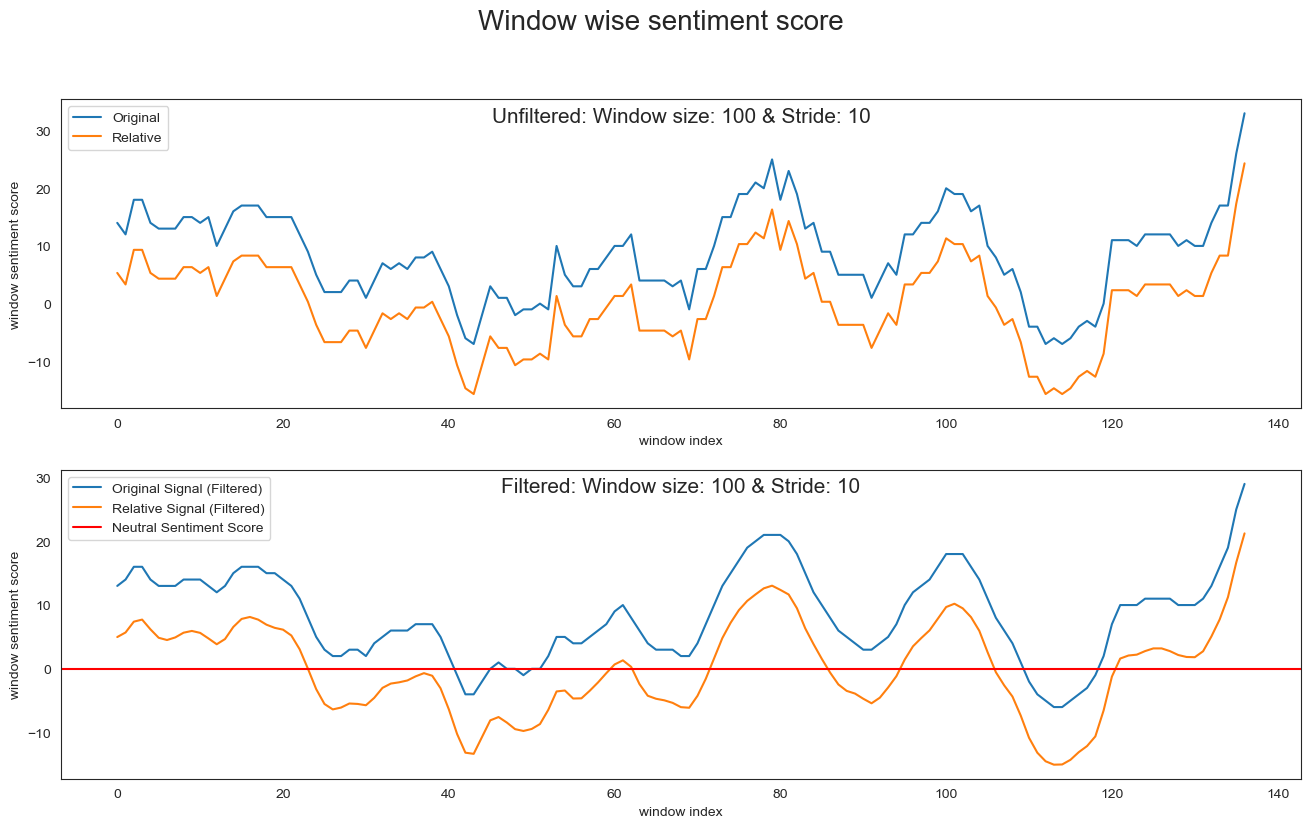

In [29]:
# Plot the sentiment over time
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
plt.rcParams['figure.dpi'] = 100

def plot_sentiments(sent_vector,J,L):
    sns.set_style("white")
    average = np.mean(sent_vector)
    # Creating a relative sentiment signal
    relative = sent_vector - average
    # Using scipy's 1d 1s gaussian filter, 2nd argument is sigma
    smooth = gaussian_filter1d(sent_vector,1)
    smooth_relative = gaussian_filter1d(relative,1)
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(16,9))
    fig.suptitle(f"Window wise sentiment score",fontsize=20)
    ax1.plot(sent_vector)
    ax1.plot(relative)
    ax1.set_title(f"Unfiltered: Window size: {J} & Stride: {L}",fontsize=15,y=0.9)
    ax1.set_xlabel("window index")
    ax1.set_ylabel("window sentiment score")
    plt.legend(["Original Signal", "Relative Signal"])
    ax2.plot(smooth)
    ax2.plot(smooth_relative)
    ax2.axhline(y=0, color='r', linestyle='-')
    ax2.set_title(f"Filtered: Window size: {J} & Stride: {L}",fontsize=15,y=0.9)
    ax2.set_xlabel("window index")
    ax2.set_ylabel("window sentiment score")
    ax1.legend(["Original", "Relative"])
    ax2.legend(["Original Signal (Filtered)", "Relative Signal (Filtered)", "Neutral Sentiment Score"])
    plt.show()
    fig.savefig("sentiment_plot.png")
    return None

plot_sentiments(sentiment_score(text_cleaned,100,10),100,10)